In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [15]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")
c = 2.99792458 * 1e5 # units: km/s

# Importing all Datasets (SCP, SNLS, Pantheon, Hubble)

In [3]:
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
data = data_scp
with open('SCPUnion2.1_mu_vs_z.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

redshift_scp = data_scp.T[1]
dist_mod_scp = data_scp.T[2] #pc
dist_mod_err_scp = data_scp.T[3] #pc
lum_dist_scp = 10**((dist_mod_scp - 25)/5)
lum_dist_err_scp = lum_dist_scp * np.log(10) * dist_mod_err_scp/5

In [4]:
data_snls = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift_snls = data_snls.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data_snls.T[4]
color_measure = data_snls.T[8]
stretch_factor = data_snls.T[6]
stretch_factor_error = data_snls.T[7]
b_band_lum_err = data_snls.T[5]
color_error = data_snls.T[9]
dist_mod_snls = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err_snls = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)

lum_dist_snls = 10**((dist_mod_snls - 25)/5)
lum_dist_err_snls = lum_dist_snls * np.log(10) * dist_mod_err_snls/5

In [5]:
data_pan = np.genfromtxt('lcparam_full_long_zhel.txt')
redshift_pan = data_pan.T[1] #cmb
dist_mod_pan = data_pan.T[4]+19.5 #pc
dist_mod_err_pan = data_pan.T[5] #pc
lum_dist_pan = 10**((dist_mod_pan - 25)/5)
lum_dist_err_pan = lum_dist_pan * np.log(10) * dist_mod_err_pan/5

In [6]:
data_og = pd.read_csv('hubble_data.csv')
distance_og = data_og.iloc[:, 1]
velocity_og = data_og.iloc[:, 2]
redshift_og = velocity_og/3e5

# Defining Functions

## Model
In general, a light source's flux, luminosity, and distance are related by
$$F=\frac{L}{4\pi r^2}$$

When doing cosmology, we must make a few modifications to this simple equation to account for the expansion and (possible) curvature of the universe. First, since the universe may not be flat, the area over which the source's light spreads out is $A=4\pi S_k(r)^2$ where
$$S_k(r) = \begin{cases}
    R_0\sin{\left(\frac{r}{R_0}\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    R_0\sinh{\left(\frac{r}{R_0}\right)}, & \kappa = -1\\
\end{cases}$$

and $R_0$ is the universe's radius of curvature. As expected, this expression simplifies to $A=4\pi r^2$ in the case of a flat universe.

Next, because the universe is expanding, the wavelength at which we observe a photon is longer than the wavelength at which it was emitted. In particular, a photon emitted with wavelength $\lambda_e$ and energy $E_e = \frac{hc}{\lambda_e}$ will have wavelength $\lambda_o = \frac{\lambda_e}{a(t_e)}$ and energy 
$$E_o = \frac{hc}{\lambda_o} = a(t_e) \frac{hc}{\lambda_e} = a(t_e)E_e = \frac{1}{1+z_e}E_e$$

when we observe it today. We can account for this by adding a factor of $\frac{1}{1+z_e}$ to the expression for the observed flux; that is,
$$F=\frac{L}{4\pi S_k(r)^2}\frac{1}{1+z_e}$$

We are not quite done yet, because we still need to incorporate the effect of cosmological time dilation. If two photons are emitted a time $\Delta t_e$ apart, then the time interval between when we observe the two photons is
$$\Delta t_o = \frac{a(t_o)}{a(t_e)}\Delta t_e = \frac{\Delta t_e}{a(t_e)} = (1+z_e)\Delta t_e$$

This means the observed flux is a factor of $\frac{1}{1+z_e}$ smaller than we previously calculated, seeing as the time interval between the arrival of successive photons is larger. Hence our final expression for the relationship between flux, luminosity, and distance (which now also depends on redshift) is
$$F = \frac{L}{4\pi S_k(r)^2}\frac{1}{(1+z_e)^2}$$

This expression can be simplified by defining the luminosity distance $d_L = S_k(r)(1+z_e)$ such that $F = \frac{L}{4\pi d_L^2}$. This relation almost gives us the desired expression relating $d_L$ and $z$, except that we still need to determine the comoving radial coordinate $r$. From the Friedmann-Robertson-Walker (FRW) metric for light moving radially inward, we can see that
$$ds^2 = 0 = -c^2dt^2 + a(t)^2dr^2$$
$$ dr^2 = c^2\frac{dt^2}{a(t)^2}$$
$$ dr = -c\frac{dt}{a(t)}$$
$$r = -\int_r^0 dr' = c\int_{t_e}^{t_0}\frac{dt}{a(t)} = c\int_{t_e}^{t_0}\frac{dt}{da}\frac{da}{a} = c\int_{a(t_e)}^{1}\frac{da}{\dot{a}a} = c\int_{a(t_e)}^{1}\frac{da}{a^2}\frac{a}{\dot{a}} = c\int_{a(t_e)}^{1}\frac{da}{a^2}\frac{1}{H(t)}$$

At this point, we can use the Friedmann equation for a matter- and dark energy-dominated universe to replace the Hubble parameter:
$$H(t)^2 = \frac{\dot{a}^2}{a^2} = H_0^2 \left(\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}+\frac{1-\Omega_0}{a^2}\right)$$
$$r=c\int_{a(t_e)}^{1}\frac{da}{a^2}\left[H_0^2 \left(\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}+\frac{1-\Omega_0}{a^2}\right)\right]^{-\frac{1}{2}}$$

We now need to convert the integration over the scale factor into an integration over the redshift. This can be accomplished using the substitution $a = \frac{1}{1+z}$ and $da = -\frac{dz}{(1+z)^2}$.
$$r=-c\int_{z_e}^{0}\frac{dz}{(1+z)^2}(1+z)^2\left[H_0^2 \left({\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_0\right)(1+z)^2\right)\right]^{-\frac{1}{2}}=cH_0^{-1}\int_0^{z_e}\left[{\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_0\right)(1+z)^2\right]^{-\frac{1}{2}}dz$$

In a matter- and dark energy-dominated universe, $\Omega_0 = \Omega_{m,0} + \Omega_{\Lambda,0}$. We can use this to simplify further:
\begin{aligned}
r&=cH_0^{-1}\int_0^{z_e}\left[{\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_{m,0}-\Omega_{\Lambda,0}\right)(1+z)^2\right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left(\Omega_{m,0} + \Omega_{m,0}z- \Omega_{m,0}\right) + \Omega_{\Lambda,0}+(1+z)^2 - \Omega_{\Lambda,0}(1+z)^2 \right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) + \Omega_{\Lambda,0}\left(1-1-2z-z^2\right) \right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz
\end{aligned}

We can now insert this expression into our equation for the luminosity distance.
$$d_L = S_k(r)(1+z_e) = (1+z_e)S_k\left(cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)$$

To evaluate the $S_k(r)$ function, we will need to derive an expression for the radius of curvature $R_0$. In Problem Set 6, we derived that $R_0$ satisfies the equation
$$\frac{\kappa}{R_0^2} = \frac{H_0^2}{c^2}(\Omega_0-1)$$
$$R_0^2 = \frac{\kappa c^2}{H_0^2}\frac{1}{{\Omega_0 - 1}}$$

Notice that this expression for $R_0$ is always nonnegative because $\Omega_0 > 1$ when $\kappa = +1$ and $\Omega_0 < 1$ when $\kappa = -1$. This result can be used to rewrite the function $S_k(r)$ in the following form.
$$S_k(r) = \begin{cases}
    \frac{c}{H_0}\frac{1}{\sqrt{\Omega_0 -1}}\sin{\left(\frac{H_0}{c}\sqrt{\Omega_0 -1}r\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    \frac{c}{H_0}\frac{1}{\sqrt{1-\Omega_0}}\sinh{\left(\frac{H_0}{c}\sqrt{1-\Omega_0}r\right)}, & \kappa = -1\\
\end{cases}$$

Let's now define $\Omega_{k,0} = 1-\Omega_0$ and $\text{sinn}(x) = \begin{cases} \sin{(x)}, & \kappa = +1\\ x, & \kappa = 0\\ \sinh{(x)}, & \kappa = -1\\\end{cases}$. Then our expression for $S_k(r)$ can be further simplified to
\begin{aligned}
S_k(r) &= \begin{cases}
    \frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\sin{\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}r\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    \frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\sinh{\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}r\right)}, & \kappa = -1\\
\end{cases}\\
&= \frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\text{sinn}{\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}r\right)}
\end{aligned}

Inserting this expression into the equation for the luminosity distance, we obtain
\begin{aligned}
d_L &= (1+z_e)\frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\text{sinn}\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)\\
&=cH_0^{-1}(1+z_e)\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\text{sinn}\left(\vert\Omega_{k,0}\vert^{\frac{1}{2}}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)
\end{aligned}

This last line is exactly Equation (2) from Riess et al. (1998), so we have just derived the equation used to fit cosmological parameters in one of the original papers on the accelerating universe! Let's now write a Python function to compute the expression on the right side of this equation.

In [7]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

In [8]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

# Plot 1: Distance versus Redshift (All Datasets)

To solve for the cosmological parameters, we will fit our luminosity distance and redshift data to the function ``D_L()`` using SciPy's curve_fit function.

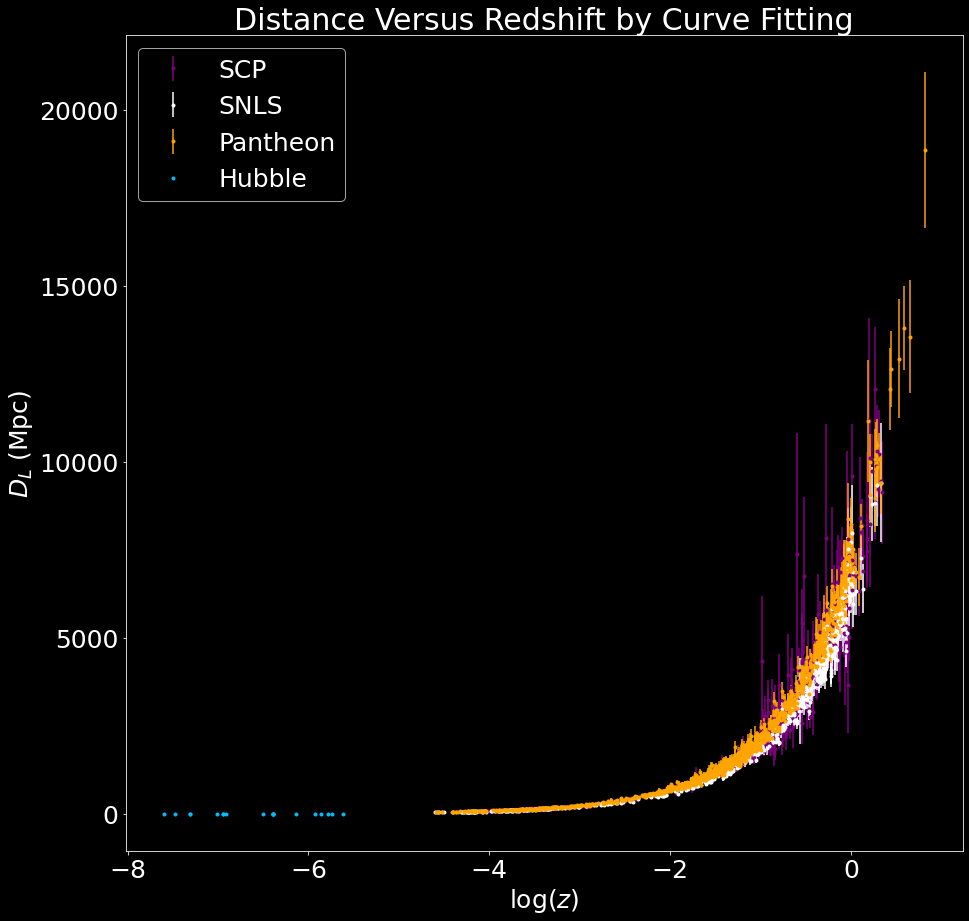

In [13]:
plt.figure(figsize = (15,15))
zz = np.linspace(np.min(redshift_scp),np.max(redshift_scp),1000)
plt.errorbar(np.log(redshift_scp),lum_dist_scp,yerr=lum_dist_err_scp,fmt='.',color='purple', label = 'SCP')
plt.errorbar(np.log(redshift_snls),lum_dist_snls,yerr=lum_dist_err_snls,fmt='.',color='white', label = 'SNLS')
plt.errorbar(np.log(redshift_pan),lum_dist_pan,yerr=lum_dist_err_pan,fmt='.',color='orange', label = 'Pantheon')
plt.errorbar(np.log(redshift_og),distance_og,fmt='.',color='deepskyblue', label = 'Hubble')


plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(loc='upper left')
plt.title("Distance Versus Redshift by Curve Fitting");

# SCP Dataset

### SciPy Fitting Distance Versus Redshift

In [17]:
bnds = ((0,0,60),(2,2,80))
poptscp, pcovscp = opt.curve_fit(D_L_helper, redshift_scp, lum_dist_scp, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_scp)
omega_m_scp, omega_lambda_scp, H_0_scp = poptscp
omega_m_err_scp, omega_lambda_err_scp, H_0_err_scp = np.sqrt(np.diag(pcovscp))

In [19]:
print("Matter density: ", "{0:.3f}".format(omega_m_scp), " ± ", "{0:.3f}".format(omega_m_err_scp))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_scp), " ± ", "{0:.2f}".format(omega_lambda_err_scp))
print("Hubble constant: ", "{0:.2f}".format(H_0_scp), " ± ", "{0:.2f}".format(H_0_err_scp))

Matter density:  0.323  ±  0.069
Dark energy density:  0.75  ±  0.11
Hubble constant:  70.49  ±  0.43


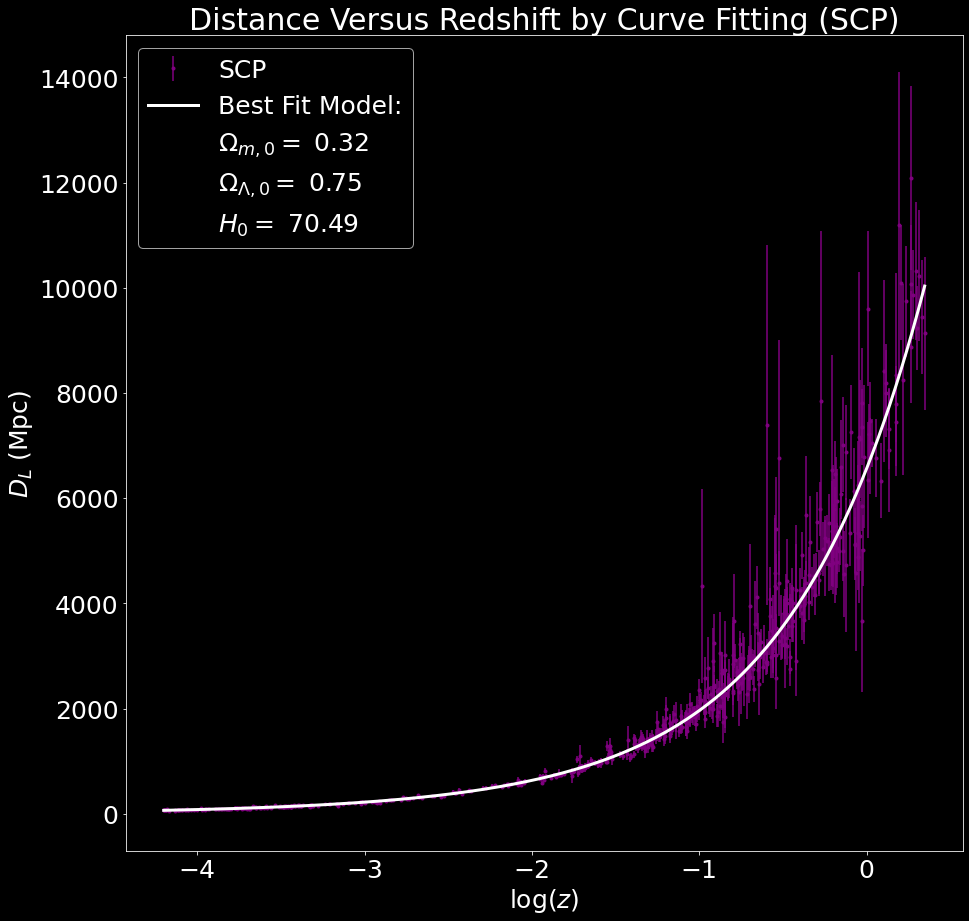

In [24]:
plt.figure(figsize = (15,15))

zz = np.linspace(np.min(redshift_scp),np.max(redshift_scp),1000)
plt.errorbar(np.log(redshift_scp),lum_dist_scp,yerr=lum_dist_err_scp,fmt='.',color='purple', label = 'SCP')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m_scp, omega_lambda_scp, H_0_scp), linewidth=3,color='white',label="Best Fit Model:")
plt.errorbar(0,0,linewidth=0,label="$\Omega_{{m,0}}=$ {0:.2f}".format(omega_m_scp))
plt.errorbar(0,0,linewidth=0,label="$\Omega_{{\Lambda,0}}=$ {0:.2f}".format(omega_lambda_scp))
plt.errorbar(0,0,linewidth=0,label="$H_0=$ {0:.2f}".format(H_0_scp))
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend()
plt.title("Distance Versus Redshift by Curve Fitting (SCP)");

We can already see that the model fits the data very well in the plot above. Now let's zoom in on the high redshift region and examine how the best fit model compares to other possible models. We will compare to three of the models examined in Figure 1 of Perlmutter et al. (1998): 
<center> 1. $\Omega_{m,0} = \Omega_{\Lambda,0} = 0.5$ </center>
<center> 2. $\Omega_{m,0} = 1, \Omega_{\Lambda,0} = 0$ </center>
<center> 3. $\Omega_{m,0} = 0, \Omega_{\Lambda,0} = 1$ </center>

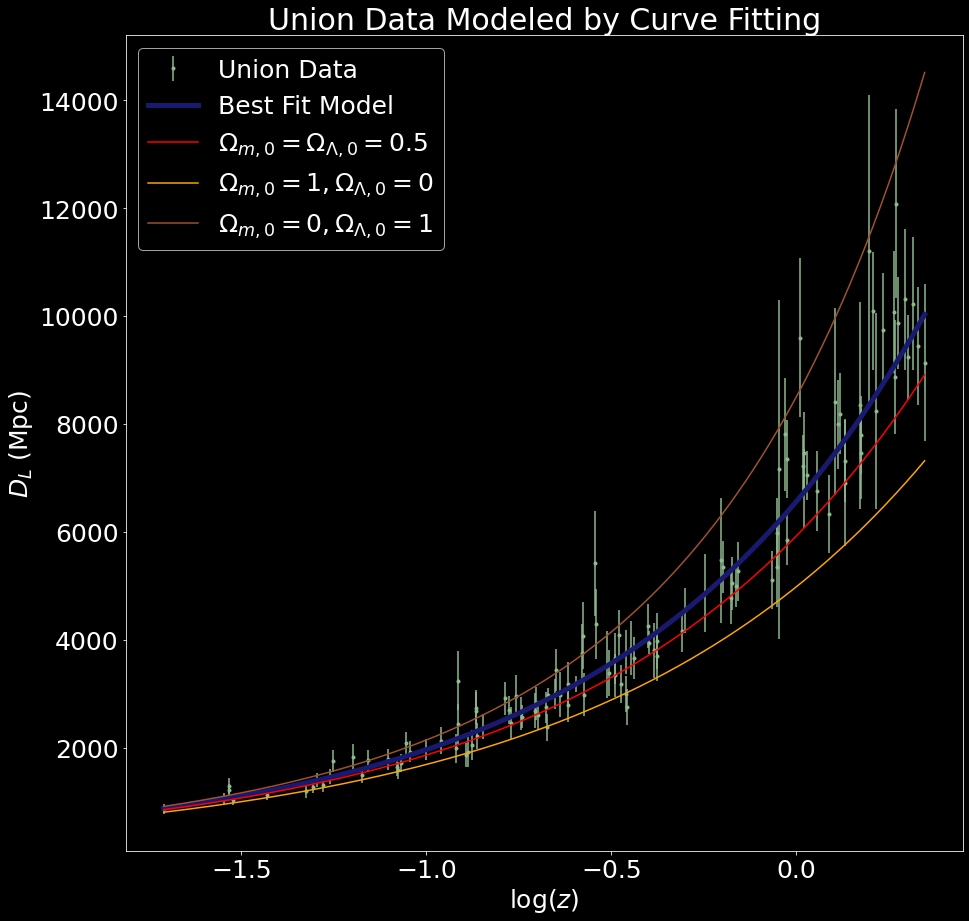

In [28]:
plt.figure(figsize = (15,15))

redshift_slice_scp = redshift_scp[int(np.round(len(redshift_scp)*4/5)):len(redshift_scp)]
lum_dist_slice_scp = lum_dist_scp[int(np.round(len(redshift_scp)*4/5)):len(redshift_scp)]
lum_dist_err_slice_scp = lum_dist_err_scp[int(np.round(len(redshift_scp)*4/5)):len(redshift_scp)]

zz = np.linspace(np.min(redshift_slice_scp),np.max(redshift_slice_scp),1000)
plt.errorbar(np.log(redshift_slice_scp),lum_dist_slice_scp,yerr=lum_dist_err_slice_scp,fmt='.',color='darkseagreen')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m_scp, omega_lambda_scp, H_0_scp), linewidth=5,color='midnightblue')
plt.errorbar(np.log(zz),D_L_helper(zz, 0.5, 0.5, H_0_scp), linewidth=1.5,color='red')
plt.errorbar(np.log(zz),D_L_helper(zz, 1, 0, H_0_scp), linewidth=1.5,color='orange')
plt.errorbar(np.log(zz),D_L_helper(zz, 0, 1, H_0_scp), linewidth=1.5,color='sienna')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model","$\Omega_{m,0} = \Omega_{\Lambda,0} = 0.5$", "$\Omega_{m,0}=1,\Omega_{\Lambda,0}=0$", "$\Omega_{m,0}=0,\Omega_{\Lambda,0}=1$"),loc='upper left')
plt.title("Union Data Modeled by Curve Fitting");

This plot demonstrates that our model fits the data better than any of the alternative models considered here. In addition, by zooming in on the highest redshift region (which is hardest to fit because of the large error bars), we can confirm visually that our model provides a good fit to the data.

### Phase Space Sampling
An alternative method for finding the best fit values of the cosmological parameters is to uniformly sample the phase space and identify which combination of parameters provides the best fit to the data. We will sample from the following ranges for the cosmological parameters.
$$ \Omega_{m,0} \in [0,1], \quad \Omega_{\Lambda,0} \in [0,1], \quad H_0 \in [60,80]$$

To evaluate the goodness of fit for each possible combination of parameters, we will compute the chi-squared statistic, which is defined by
$$\chi^2 = \sum_i \frac{(d_{obs,i}-d_{exp,i})^2}{d_{err,i}^2}$$

where the observed luminosity distances are $d_{obs,i}\pm d_{err,i}$, the expected luminosity distances (based on our choice of cosmological parameters) are $d_{exp,i}$, and the sum is taken over all data points.

In [ ]:
num_points = 20

omega_m_range = np.linspace(0,1.5,num_points)
omega_lambda_range = np.linspace(0,1.5,num_points)

H_0_range = np.linspace(60,80,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
H_0_best = H_0_range[0]
expected = D_L_helper(redshift_scp, omega_m_scp, omega_lambda_scp, H_0_scp)
chi2_best = np.sum((lum_dist_scp - expected)**2/lum_dist_err_scp**2)
k_best = 0


chi2_arr = np.zeros((num_points,num_points,num_points))
new_array = np.zeros((num_points,num_points))

for k in np.arange(np.size(H_0_range)):
    for i in np.arange(np.size(omega_m_range)):
        for j in np.arange(np.size(omega_lambda_range)):
                omega_m = omega_m_range[i]
                omega_lambda = omega_lambda_range[j]
                H_0 = H_0_range[k]
                expected = D_L_helper(redshift_scp, omega_m, omega_lambda, H_0)
                if np.isnan(np.any(expected)) == False:
                    chi2 = np.sum((lum_dist_scp - expected)**2/lum_dist_err_scp**2)
                    chi2_arr[i][j][k] = chi2
                    new_array[i][j] = chi2
                    if chi2 < chi2_best:
                        omega_m_best = omega_m
                        omega_lambda_best = omega_lambda
                        H_0_best = H_0
                        chi2_best = chi2
                        k_best = k
                
print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

<ipython-input-7-f655e3600710>:12: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
<ipython-input-7-f655e3600710>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(integrand,0,z)[0]


In [ ]:
chi2_slice = chi2_arr[:][:][k_best]
plt.figure(figsize = (15,15))
im = plt.imshow(chi2_slice, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
#plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SCP Data)')
plt.plot(omega_m_best,omega_lambda_best,'r*',markersize=20)
plt.show()


At this point, we have calculated the best fit values of the cosmological parameters $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$. With these parameters fixed, we can use the Friedmann equation to determine how the system will evolve in time. For a flat matter- and dark energy-dominated universe, the Friedmann equation takes the following form:
$$\frac{\dot{a}^2}{a^2} = H_0^2\left[\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}\right]$$
$$\frac{da}{dt} = H_0 \sqrt{\frac{\Omega_{m,0}}{a} + \Omega_{\Lambda,0}a^2}$$

To test that our integration is working, we will first consider a matter-only universe, for which the Friedmann equation can be solved by hand.
$$\frac{da}{dt} = H_0 \sqrt{\frac{\Omega_{m,0}}{a}}$$
$$\sqrt{a}da = H_0\sqrt{\Omega_{m,0}}dt$$
$$\int_0^{a(t)} \sqrt{a}da = H_0 \sqrt{\Omega_{m,0}}\int_0^t dt$$
$$\frac{2}{3}a(t)^{\frac{3}{2}} = H_0\sqrt{\Omega_{m,0}}t$$
$$a(t) = \left(\frac{3}{2}H_0\sqrt{\Omega_{m,0}}t\right)^{\frac{2}{3}}$$

In [ ]:
t_range = 0,20e9 # in units of t0
a0 = np.array([1e-15]) # pick some small but nonzero value
H_0_yrs = H_0 / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_m/a)
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
matter_num = soln.y[0]

matter_exact = (3/2 * H_0_yrs * np.sqrt(omega_m) * times)**(2/3)

plt.plot(times, matter_num, label='Numerical integration')
plt.plot(times, matter_exact, label='Exact integration')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.legend()
plt.title("Matter-Dominated Universe");

In the plot above, the scale factors obtained using numerical and exact integration coincide with each other, which is a sign that our numerical integrator is working well. We can perform a similar test for a single-component universe containing only dark energy. In that case, the Friedmann equation simplifies as follows.
$$\frac{da}{dt} = H_0\sqrt{\Omega_{\Lambda,0}}a$$
$$\frac{1}{a}da = H_0\sqrt{\Omega_{\Lambda,0}}dt$$
$$\int_{a(0)}^{a(t)} \frac{1}{a}da = H_0\sqrt{\Omega_{\Lambda,0}}\int_0^tdt$$
$$\ln{\left(\frac{a(t)}{a(0)}\right)} = H_0\sqrt{\Omega_{\Lambda,0}}t$$
$$a(t) = a(0)\cdot e^{H_0\sqrt{\Omega_{\Lambda,0}}t}$$

We cannot set $a(t) = a(0)$ because then $a(t)$ would remain zero for all times. Instead, to solve for the integration constant $a(0)$ we will impose the condition $a(t_0) = 1$ where $t_0 = t_H = \frac{1}{H_0}$. 
$$a(0) = a(t_0) e^{-H_0\sqrt{\Omega_{\Lambda,0}}t_0} = e^{-\sqrt{\Omega_{\Lambda,0}}}$$
$$a(t) = e^{\sqrt{\Omega_{\Lambda_0}} \left( H_0 t - 1\right)}$$

Now let's go ahead and integrate the scale factor for a dark energy-dominated universe using both the exact solution calculated above and numerical integration.

In [ ]:
t_range = 0,20e9 # in units of t0
a0 = np.array([np.exp(-np.sqrt(omega_lambda))])
H_0_yrs = H_0 / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_lambda) * a
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
de_num = soln.y[0]

de_exact = np.exp(np.sqrt(omega_lambda) * (H_0_yrs * times - 1))

plt.plot(times, de_num, label='Numerical integration')
plt.plot(times, de_exact, label='Exact integration')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.legend()
plt.title("Dark Energy-Dominated Universe");

The curves for the scale factor obtained using numerical integration and exact integration coincide, which indicates that our numerical integration is working well. We are now ready to integrate the full Friedmann equation, including both matter and dark energy terms. For comparison, we will also include the scale factors for the two single component universes (matter only and dark energy only) on the same plots.

In [ ]:
t_range = 0,20e9 # in units of t0
a0 = np.array([1e-15]) # pick some small but nonzero value
H_0_yrs = H_0 / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_m/a + omega_lambda * a**2)
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
total_num = soln.y[0]

plt.plot(times, total_num, label='Numerical integration')
plt.plot(times, matter_exact, label='Matter only')
plt.plot(times, de_exact, label='Dark energy only')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

Unfortunately, the Friedmann equation including both $\Omega_{m,0}$ and $\Omega_{\Lambda,0}$ cannot easily be integrated by hand to check the results of the numerical integration. However, we obtained the following exact solution from Wolfram Alpha:
$$a(t) = \frac{\sqrt[3]{\Omega_{m,0}}\tanh^{\frac{2}{3}}{\left(\frac{3}{2}\left(C\sqrt{\Omega_{\Lambda,0}} + H_0\sqrt{\Omega_{\Lambda,0}} t\right)\right)}}{\sqrt[3]{\Omega_{L,0} - \Omega_{L,0}\tanh^2{\left(\frac{3}{2}\left(C\sqrt{\Omega_{\Lambda,0}}+H_0\sqrt{\Omega_{\Lambda,0}} t\right)\right)}}}$$

Since the Friedmann equation is a first-order differential equation, we expect one constant of integration. This constant $C$ is fixed by the initial condition $a(0) = 0$. Observe that
$$a(0) = \frac{\sqrt[3]{\Omega_{m,0}}\tanh^{\frac{2}{3}}{\left(\frac{3}{2}C\sqrt{\Omega_{\Lambda,0}} \right)}}{\sqrt[3]{\Omega_{L,0} - \Omega_{L,0}\tanh^2{\left(\frac{3}{2}C\sqrt{\Omega_{\Lambda,0}}\right)}}}= 0$$

The hyperbolic tangent function vanishes at $0$, so we can let $C=0$ to ensure the initial condition $a(0) = 0$ will be satisfied. Therefore, the exact solution fitted to initial conditions is
$$a(t) = \frac{\sqrt[3]{\Omega_{m,0}}\tanh^{\frac{2}{3}}{\left(\frac{3}{2} H_0\sqrt{\Omega_{\Lambda,0}} t\right)}}{\sqrt[3]{\Omega_{L,0} - \Omega_{L,0}\tanh^2{\left(\frac{3}{2}H_0\sqrt{\Omega_{\Lambda,0}} t\right)}}}$$

Let's implement this exact solution in a function and plot it against the solution obtained using numerical integration.

In [ ]:
def a(t,omega_m,omega_lambda,H_0):
    num = omega_m**(1/3) * np.tanh(3/2 * H_0 * np.sqrt(omega_lambda) * t)**(2/3)
    den = (omega_lambda - omega_lambda * np.tanh(3/2 * H_0 * np.sqrt(omega_lambda) * t)**2)**(1/3)
    return num/den

In [ ]:
def a_helper(times,omega_m,omega_lambda,H_0):
    return [a(t,omega_m,omega_lambda,H_0) for t in times]

In [ ]:
total_exact = a_helper(times,omega_m,omega_lambda,H_0_yrs)

plt.plot(times, total_exact, label='Exact integration')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

This curve obtained using exact integration for the matter- and dark energy-dominated universe looks very similar to the curve obtained using numerical integration. Indeed,  when we plot the two solutions together they cannot be distinguished because the two curves lie on top of each other. This provides confirmation that our scale factor integrator is working properly. In the next cell we will plot the scale factor as a function of time for all three universes considered so far (matter and dark energy, matter only, and dark energy only).